In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from IPython.html.widgets import interact
plt.rcParams['figure.figsize'] = (12.0, 6.0)

from dmp import (SimpleDmp, SinDmp, CanonicalSystem, SinDmpWithCS,
                 SinDmpWithCS2, Rbf, DmpWithImitation)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
weights = np.asarray([0.0473452, 0.0520401, 0.0591316, 0.0680199, 0.0785818,
                      0.0880537, 0.0966840, 0.1020010, 0.1046910, 0.1081900,
                      0.1091850, 0.1088570, 0.1091380, 0.1098000, 0.1113270,
                      0.1125070, 0.1166700, 0.1220130, 0.1230260, 0.1191270,
                      0.1118230, 0.1028320, 0.0929165, 0.0849752, 0.0785847,
                      0.0736237, 0.0726080, 0.0763474, 0.0838251, 0.0909338,
                     -0.376493,-1.72607,  -3.86127,  -6.67567, -10.053,
                     -13.8778, -18.0397, -22.4229, -26.9437, -31.4854, -35.9625,
                     -40.2899, -44.3868, -48.1424, -51.4924, -54.3781, -56.718,
                     -58.4685, -59.5793, -59.971, -59.9841, -51.0547, -27.0491,
                      7.32804, 46.7509, 85.4871, 117.319, 136.255])

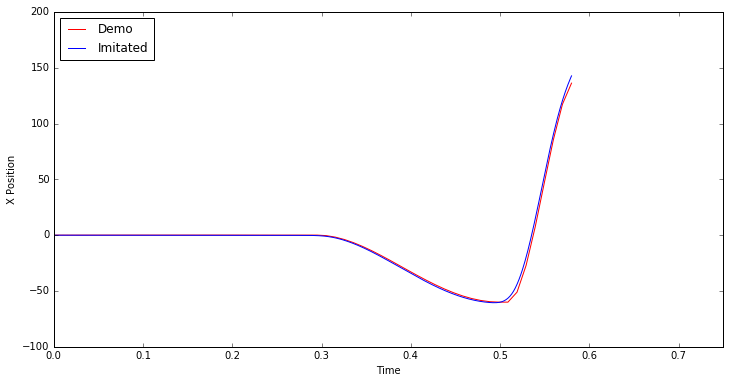

<function __main__.plotImitateDmp>

In [3]:
def plotImitateDmp(g=weights[-1], T=0.01 * len(weights), y0=weights[0], scale=False):
    dt = 0.01
    executionTime = dt * len(weights)

    lastPhaseValue = 0.1
    numWeights = 100
    overlap = 0.2
    endTime = executionTime
    times, step = np.linspace(start=0.0, stop=executionTime, num = len(weights),
                              retstep=True)
    endPos = weights[-1]

    cs = CanonicalSystem(executionTime, lastPhaseValue)
    dmp = DmpWithImitation(executionTime, weights[0], (weights[1] - weights[0]) / dt,
                           weights[len(weights) - 1], cs, numWeights, overlap, scale)
    dmp.imitate(times, weights, dt)

    cs2 = CanonicalSystem(T, lastPhaseValue)
    dmp.reset(cs2, g, T, y0)
    ts, ys, yds = dmp.run(0.001)

    plt.plot(times, weights,"r")
    plt.plot(ts, ys)
    plt.legend(["Demo", "Imitated"], loc="upper left")
    plt.xlabel("Time")
    plt.ylabel("X Position")
    plt.xlim(0.0, 0.75)
    plt.ylim(-100, 200)
    plt.show()


interact(plotImitateDmp, g=(-10, 200, 1), T=(0.1, 1.5, 0.1), y0=(-30, 30, 1))

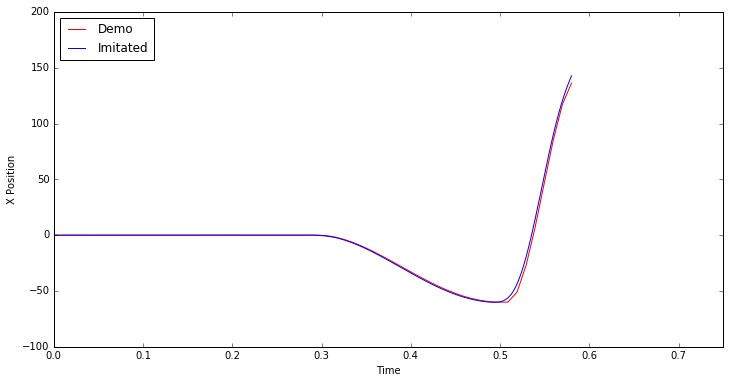

<function __main__.plotImitateDmpScale>

In [4]:
def plotImitateDmpScale(g=weights[-1], T=0.01 * len(weights),
                        y0=weights[0]):
    plotImitateDmp(g, T, y0, scale=True)


interact(plotImitateDmpScale, g=(-10, 200, 1), T=(0.1, 1.5, 0.1), y0=(-30, 30, 1))

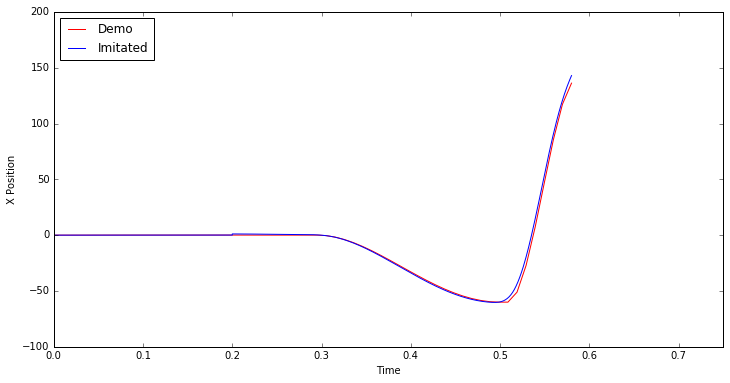

<function __main__.plotPerturbateDmp>

In [5]:
def plotPerturbateDmp(p_loc=0.2, p_strength=1.0):
    dt = 0.01
    executionTime = dt * len(weights)

    lastPhaseValue = 0.1
    numWeights = 100
    overlap = 0.2
    endTime = executionTime
    times, step = np.linspace(start=0.0, stop=executionTime,
                              num=len(weights), retstep=True)
    endPos = weights[-1]


    cs = CanonicalSystem(executionTime, lastPhaseValue)
    dmp = DmpWithImitation(executionTime, weights[0], (weights[1] - weights[0]) / dt,
                           weights[-1], cs, numWeights, overlap, False)
    dmp.imitate(times, weights, dt)
    
    (ts, ys, _) = dmp.run(0.001, endTime=p_loc)
    dmp.y += p_strength
    (ts2, ys2, _) = dmp.run(0.001, startTime=p_loc)
    ts.extend(ts2)
    ys.extend(ys2)
    plt.plot(times, weights,"r")
    plt.plot(ts, ys)
    plt.legend(["Demo", "Imitated"], loc="upper left")
    plt.xlabel("Time")
    plt.ylabel("X Position")
    plt.xlim(0.0, 0.75)
    plt.ylim(-100, 200)
    plt.show()


interact(plotPerturbateDmp, p_loc=(0.01, 0.5, 0.01), p_strength=(-200, 200, 1))

In [6]:
%%html
<style>
table,td,tr,th {border:none!important}
</style>

#Introduction to Discrete Dynamic Movement Primitives
  
  

### Arne Böckmann 

##What are DMPs
<table>
  <tr>
    <td>
    <ul style="list-style-type:disc">
        <li>Dynamical systems</li>
        <li>Represent goal directed movements in joint or task space </li>
        <li>Guaranteed to converge to the goal</li>
        <li>Scale spatial and temporal</li>
        <li>Robust against pertubations</li>
        <li>Adaptable online</li>
        <li>Extendable</li>
        <li>Learnable from demonstration</li>
    </ul>
    </td>
    <td><img src="dmp.png"></td>
  </tr>
</table>



##Basic Idea

* Use well understood stable dynamical system with convenient properties
* Add nonlinear terms to achieve the desired movement behavior


##Damped Spring Model
\begin{align}
\dot{z} &= \alpha_z(\beta_z(g-y)-z)\\
\dot{y} &= z
\end{align}

$y$ - position, $g$ - goal position

$\alpha_z$, $\beta_z$ - Dampening constants. Use $\beta_z = \alpha_z/4$ for critical dampening.


##Damped Spring Model
Difference Equations
\begin{align}
z_t &= z_{t-1} + \alpha_z(\beta_z(g-y_{t-1})-z_{t-1}) * \Delta t\\
y_t &= y_{t-1} + z_{t-1} * \Delta t
\end{align}

##Damped Spring Model (Demo)

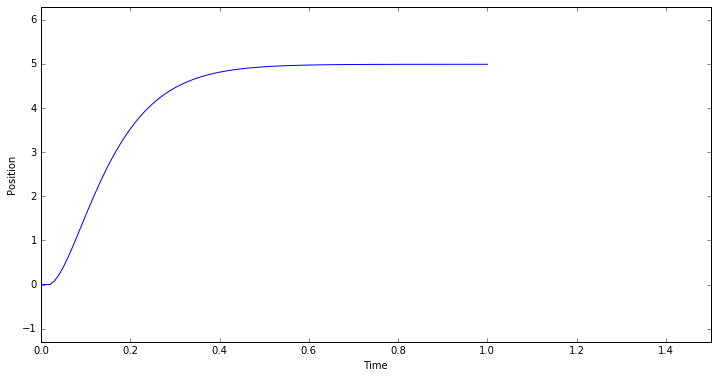

<function __main__.plotPD>

In [7]:
def plotPD(g=5.0, y_start=0.0, yd_start=0.0):
    dt = 0.01
    T = 1.0
    dmp = SimpleDmp(T, y_start, yd_start, g)
    ts, ys, yds, _ = dmp.run(dt, 0.0, T)
    plt.plot(ts, ys)
    plt.xlim(0, 1.5)
    plt.ylim(-1.3, 6.3)
    plt.xlabel("Time")
    plt.ylabel("Position")
    plt.show()


interact(plotPD, g=(-2.0, 6.0, 0.1), y_start=(-1.0, 2.0, 0.1),
         yd_start=(-50.0, 50.0, 5.0))     

### Adding temporal scaling
* Add temporal scaling factor $\color{red}\tau$
\begin{align}
\color{red}\tau\dot{z} &= \alpha_z(\beta_z(g-y)-z)\\
\color{red}\tau\dot{y} &= z\\\\
z_t &= z_{t-1} + \frac{\alpha_z(\beta_z(g-y_{t-1})-z_{t-1}) * \Delta t}{\color{red}\tau}\\
y_t &= y_{t-1} + \frac{z_{t-1} * \Delta t}{\color{red}\tau}
\end{align}


### Adding temporal scaling (Demo)

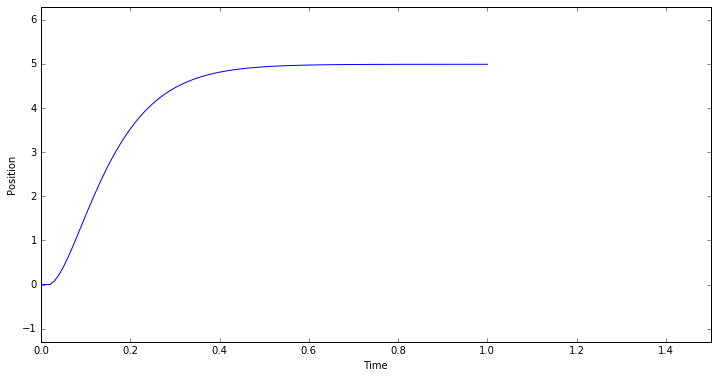

<function __main__.plotPDT>

In [8]:
def plotPDT(g=5.0, T=1.0):
    y_start = 0.0
    yd_start = 0.0
    dt = 0.01    
    dmp = SimpleDmp(T, y_start, yd_start, g)
    ts, ys, yds, _ = dmp.run(dt, 0.0, T)
    plt.plot(ts, ys)
    plt.xlim(0, 1.5)
    plt.ylim(-1.3, 6.3)
    plt.xlabel("Time")
    plt.ylabel("Position")
    plt.show()


interact(plotPDT, g=(-2.0, 6.0, 0.1), T=(0.01, 1.5, 0.1))     

##Shaping the Trajectory (The Transformation System)
Introduce the forcing term $\color{red}f$
\begin{align}
z_t &= z_{t-1} + \frac{\alpha_z(\beta_z(g-y_{t-1})-z_{t-1} + \color{red}f) * \Delta t}{\tau}\\
\end{align}
* 'forces' the system into a certain shape.
* could be a function of time: $f(t)$

###Shaping the Trajectory (Demo)

* set $f(t) = K sin(t)$

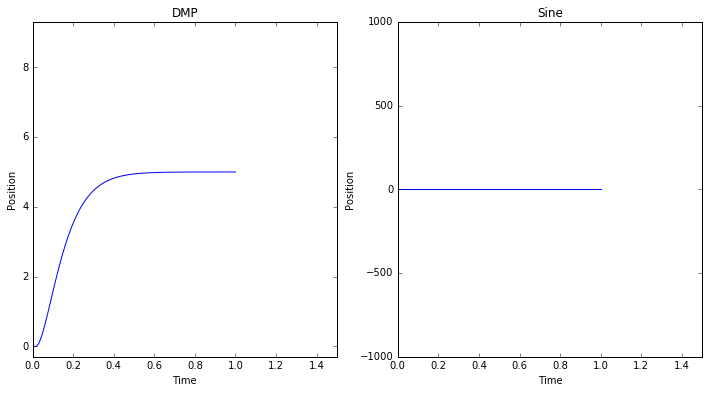

<function __main__.plotSin>

In [9]:
def plotSin(K=0):
    g = 5.0
    T = 1.0
    dt = 0.01    
    y_start = 0.0
    yd_start = 0.0
    dmp = SinDmp(T, y_start, yd_start, g, K)
    ts, ys, yds, fs = dmp.run(dt, 0.0, T)
    plt.subplot(121)
    plt.title("DMP")
    plt.plot(ts, ys)
    plt.xlim(0, 1.5)
    plt.ylim(-0.3, 9.3)
    plt.xlabel("Time")
    plt.ylabel("Position")
    plt.subplot(122)
    plt.title("Sine")
    plt.plot(ts, fs)
    plt.xlim(0, 1.5)
    plt.ylim(-1000, 1000)
    plt.xlabel("Time")
    plt.ylabel("Position")
    plt.show()


interact(plotSin, K=(0, 1000, 10))

##Restoring Goal Convergence
* Influence of $f$ should diminish over time
* Introducing the phase $\color{red}s$
\begin{align}
z_t &= z_{t-1} + \frac{\alpha_z(\beta_z(g-y_{t-1})-z_{t-1} + \color{red}sf) * \Delta t}{\tau}\\
\end{align}

* $\color{red}s$ starts at 1 and exponentially decays to 0

##Restoring Goal Convergence (The Canonical System)
$s$ can be generated by the following system:
\begin{align}
\tau \dot{s} = -\alpha_s s\\\\
s_t = s_{t-1} + \frac{-\alpha_s \Delta t}{T}
\end{align}
* $\alpha_s$ defines how fast the system decays.


##Canonical System (Demo)

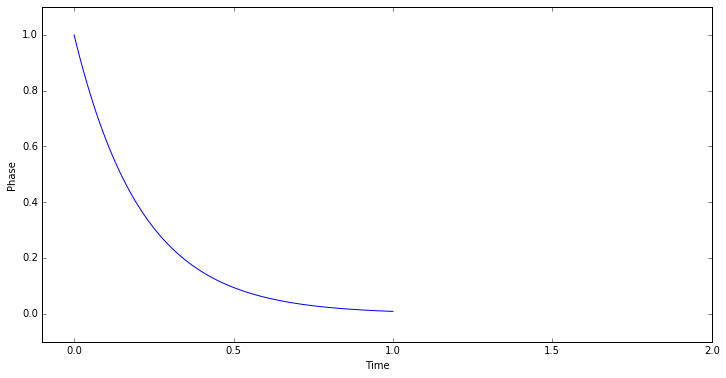

<function __main__.plotCS>

In [10]:
def plotCS(T = 1.0):
    dt = 0.01
    cs = CanonicalSystem(T)
    times = []
    values = []

    t = 0.0
    while(t < T):
        times.append(t)
        values.append(cs.s)
        cs.step(dt)
        t += dt
    #get value from last step
    times.append(t)
    values.append(cs.s)
    plt.plot(times, values)
    plt.xlim(-0.1, 2.0)
    plt.ylim(-0.1, 1.1)
    plt.xlabel("Time")
    plt.ylabel("Phase")
    plt.show()


interact(plotCS, T=(0.1, 2.0))

##Sine Forcing Term and Canonical System (Demo)

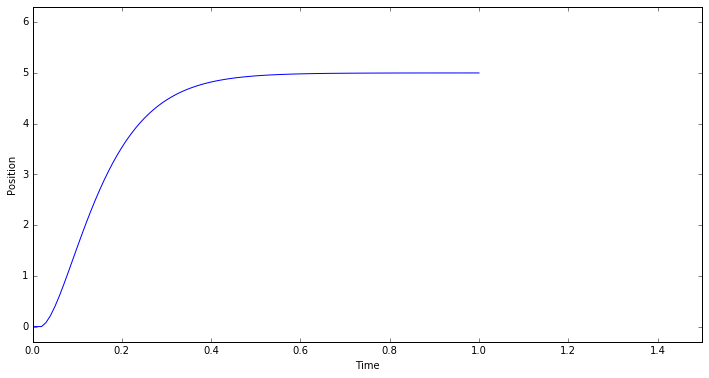

<function __main__.plotSinCS>

In [11]:
def plotSinCS(sin_scale = 1.0, T = 1.0, g=5.0):
    dt = 0.01    
    y_start = 0.0
    yd_start = 0.0
    s = sin_scale
    dmp = SinDmpWithCS(T, y_start, yd_start, g, s)
    ts, ys, yds, _ = dmp.run(dt, 0.0, T)
    plt.plot(ts, ys)
    plt.xlim(0, 1.5)
    plt.ylim(-0.3, 6.3)
    plt.xlabel("Time")
    plt.ylabel("Position")
    plt.show()


interact(plotSinCS, sin_scale=(-1000, 1000, 1.0),
         T=(0.1, 1.5, 0.1), g=(0.0, 6.0, 0.1))

##Restoring Temporal Scaling
 * Because $f$ is time dependent
 * Solution: Replace the time dependency with a phase dependency
 * $f = f(s)$

##Restoring Temporal Scaling (Demo)

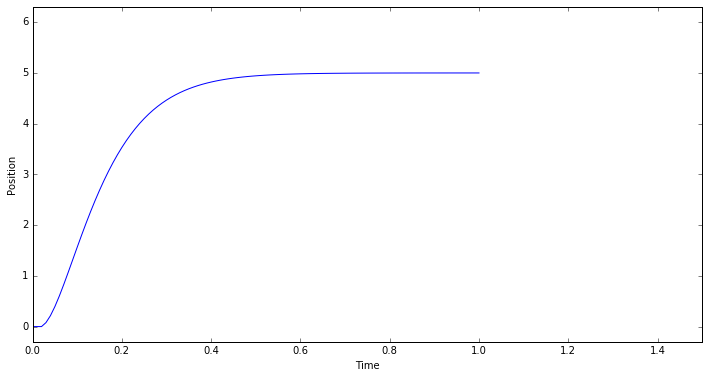

<function __main__.plotSinCS2>

In [12]:
def plotSinCS2(sin_scale = 1.0, T = 1.0, g=5.0):
    dt = 0.01    
    y_start = 0.0
    yd_start = 0.0
    s = sin_scale
    dmp = SinDmpWithCS2(T, y_start, yd_start, g, s)
    ts, ys, yds, _ = dmp.run(dt, 0.0, T)
    plt.plot(ts, ys)
    plt.xlim(0, 1.5)
    plt.ylim(-0.3, 6.3)
    plt.xlabel("Time")
    plt.ylabel("Position")
    plt.show()


interact(plotSinCS2, sin_scale=(-1000, 1000, 1.0), T=(0.1, 1.5, 0.1), g=(0.0, 6.0, 0.1))

##Imitating arbitrary Trajectories
* Set $f(s) = \frac{\sum_{i=1}^N \psi_i(s)w_i}{\sum_{i=1}^N \psi_i(s)}$
 * $\psi_i$ are fixed basis functions (e.g. radial basis functions)
 * $N$ is the number of basis functions/weights
 * $f$ can be shaped by adjusting the $w_i$
 * $f$ can imitate any given trajectory using locally weighted regression (not part of this talk)

####Imitating arbitrary Trajectories
This is a part of B-Human's current kick trajectory

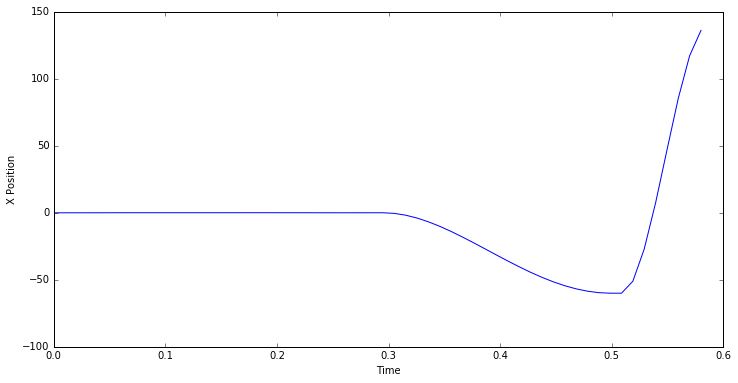

In [13]:
plt.plot(np.linspace(start=0.0, stop=0.01 * len(weights), num=len(weights)), weights); plt.xlabel("Time"); plt.ylabel("X Position")

##Imitating arbitrary Trajectories (Demo)

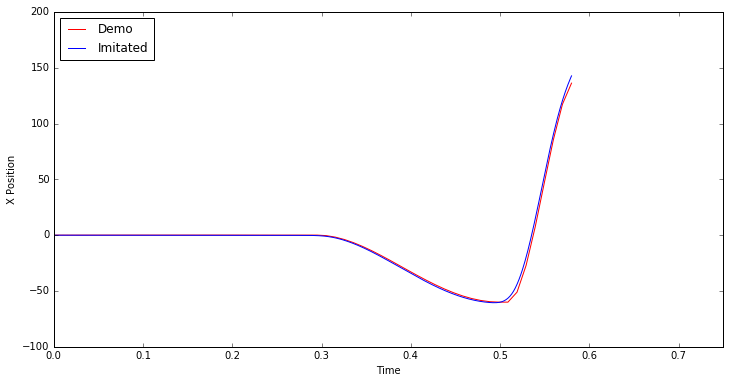

<function __main__.plotImitateDmp>

In [14]:
interact(plotImitateDmp, g=(-10, 200, 1), T=(0.1, 1.5, 0.1), y0=(-30, 30, 1))

##Adding Spatial Scaling
* $w_i$ are learned for one specific goal position
 * Are too strong/weak for other goal positions
* Solution: Scale the forcing term according to the difference $\color{red}d$ between the original trajectory and the modified one
\begin{align}
\color{red}d &= (y_e - y_0)/(y_{de} - y_{d0})\\
z_t &= z_{t-1} + \frac{\alpha_z(\beta_z(g-y_{t-1})-z_{t-1} + \color{red}dsf) * \Delta t}{\tau}\\
\end{align}

   * $y_{de}$ and $y_{d0}$ - End and start position of the demonstrated trajectory

##Spatial Scaling (Demo)

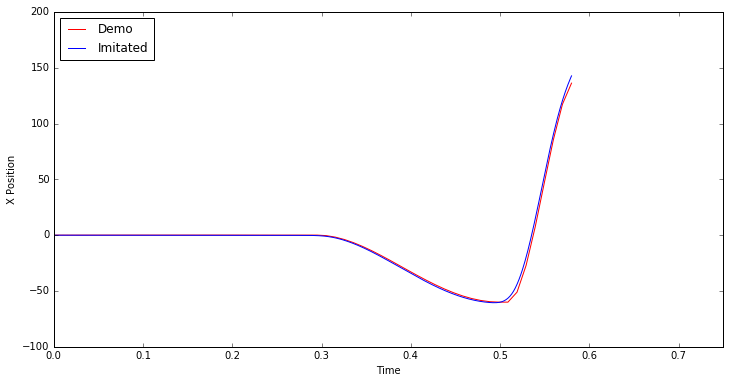

<function __main__.plotImitateDmp>

In [15]:
interact(plotImitateDmp, g=(-10, 200, 1), T=(0.1, 1.5, 0.1), y0=(-30, 30, 1))

##Perturbation robustness

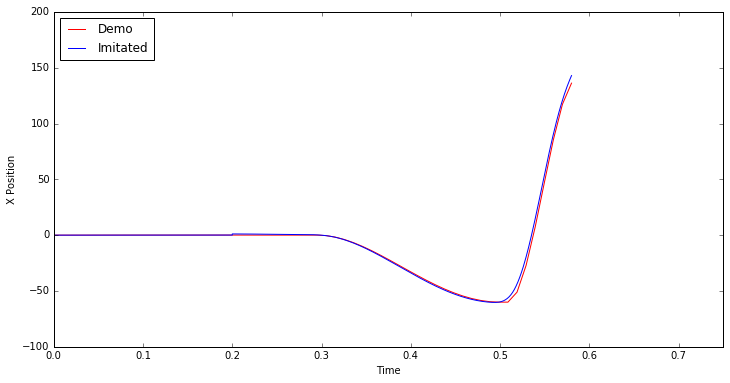

<function __main__.plotPerturbateDmp>

In [16]:
interact(plotPerturbateDmp, p_loc=(0.01, 0.5, 0.01), p_strength=(-200, 200, 1))

##Extension to multiple dimensions
* As long as the dimensions are independent
 * Use one Transformation System per dimension
 * Use the same Canonical System for all dimensions

##Extensions
* Oscillating movements
* Enforcing a goal velocity
* Obstacle avoidance
* Closed-loop perception-action control
* Movement synchroization
* Rotation Dmps (quaternion based and rotation matrix based)
* ...

##Recap
* Dmps are a toolbox to imitate movements and modify them on the fly
* Robust against perturbations
* Always converge to the goal in time
* Can be executed and modified in real-time
* Can be extended to multiple dimensions
* Can be extended using arbitrary coupling terms to achieve any desired behavior

##Recap
#### Parameters
* $\alpha_z$ and $\beta_z$ are constant $\rightarrow$ can be ignored
* $\alpha_s$ can be calculated automatically
* Good values for the parameters of $f$ can be found automatically
* The weights of $f$ can be learned from demonstration using locally weighted regression

##Examples


In [17]:
from IPython.display import YouTubeVideo
YouTubeVideo('Ge0GduY1rtE')

In [18]:
from IPython.display import YouTubeVideo
YouTubeVideo('SH3bADiB7uQ')  